# Compressão JPEG

Neste estudo iremos seguir os passo de compressão do JPEG, implementando os principais no GNU Octave.

Leia mais sobre o JPEG na [Wikipedia](https://en.wikipedia.org/wiki/JPEG).

Abaixo apresentamos o diagrama esquemático JPEG.

![](imgs/jpegstd.png)

No GNU Octave, vamos inicialmente carregar os pacotes necessários e ler a imagem que será utilizada na demonstração. Como iremos realizar cálculos em ponto flutuante, iremos converter a imagem (originalmente em uint8) para double. 

OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set


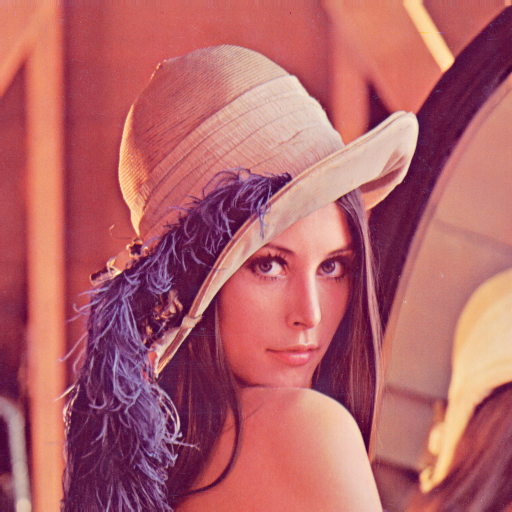

In [1]:
pkg load signal
pkg load image
pkg load communications
X = imread ('imgs/lena.png');
% para exibir a imagem basta utilizar a função: imshow(X)
% por algum bug no notebook, está sendo necessário fazer a conversão im2double antes
Xd = im2double(X);
imshow(Xd);

O primeiro passo da compressão JPEG é converter a imagem de RGB para YCbCr. Ao realizar esta mudança de espaço de cores estaremos agora representando a imagem através de uma componente de luminância (Y) e duas componente de crominância (Cb e Cr). Esta mudança é feita pois degradação na informação de crominância é menos perceptível do que degradação na informação de luminância. Como veremos adiante, esta característica da percepção visual humana será explorada através da realização de subamostragem de crominância e maior quantização dos coeficientes DCT de crominância. Descartando assim mais informação de crominância é possível reduzir o tamanho do arquivo resultante, com menor perda perceptível de qualidade. Podemos ajustar quanta informação será perdida e assim conseguir diferentes resultados em qualidade e fator de compressão.

O padrão ainda prevê a possibilidade de aplicar uma subamostragem nas componentes de crominância, o que não é abordado no presente exemplo.

In [2]:
Xycbcr = double(rgb2ycbcr(X));
whos Xycbcr

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        Xycbcr    512x512x3                6291456  double

Total is 786432 elements using 6291456 bytes



Abaixo apresentamos cada um dos canais da imagem em RBG e YCbCr.

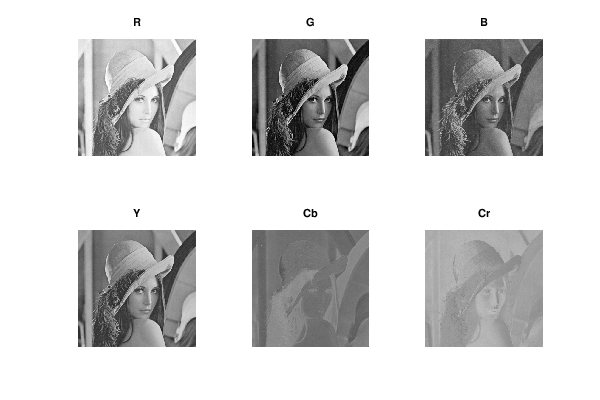

In [3]:
figure(1,'position',[0,0,600,400]);
subplot(2,3,1); imshow(X(:,:,1)); title('R');
subplot(2,3,2); imshow(X(:,:,2)); title('G');
subplot(2,3,3); imshow(X(:,:,3)); title('B');
subplot(2,3,4); imshow(uint8(Xycbcr(:,:,1))); title('Y');
subplot(2,3,5); imshow(uint8(Xycbcr(:,:,2))); title('Cb');
subplot(2,3,6); imshow(uint8(Xycbcr(:,:,3))); title('Cr');

O próximo passo é a separação da imagem em blocos de 8x8. Esta etapa é realizada para se aplicar a DCT 2D em cada um dos blocos. Iremos então realizar a DCT em blocos utilizando a função 'blockproc'. Usualmente utiliza-se blocos de tamanho 8x8 ou 16x16. O tamanho é uma potência de 2 para ter menor custo computacional. Além disso o tamanho dos blocos deve ser propício para que os próximos passos da codificação (DPCM sobre os coeficientes DC e RLE sobre os coeficientes AC) sejam mais eficientes.

Primeiramente iremos definir a operação de DCT 2D através de uma [função anônima](https://en.wikipedia.org/wiki/Anonymous_function).

In [4]:
% DCT
T = dctmtx(8);
dct = @(block_struct) T * block_struct * T';

Então podemos aplicar a DCT 2D em blocos de 8x8 em cada uma das componentes (Y, Cb e Cr) da imagem. 

In [5]:
for c=1:size(X,3),
  B(:,:,c) = blockproc(Xycbcr(:,:,c),[8 8],dct);
endfor
whos B

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        B         512x512x3                6291456  double

Total is 786432 elements using 6291456 bytes



O próximo passo é realizar a quantização dos coeficientes. Para tanto utilizaremos a tabela de quantização padrão do JPEG.

As tabelas estão armazenadas no arquivo ```qtable.default.txt```, cujo conteúdo é exibido abaixo.

In [6]:
quality = 1; % fator de qualidade geral
colorquality = 1; % fator de qualidade para crominancia
Q = load('qtable.default.txt');
m(:,:,1) = Q(1:8,:) * quality;
m(:,:,2) = m(:,:,3) = Q(9:end,:) * quality * colorquality;

Observe que foram utilizadas duas variáveis para controlar o fator de qualidade (e compressão): ```quality``` (controle geral) e ```colorquality``` (apenas para a crominância). Posteriormente, mude os valores e observe os efeitos na qualidade da imagem.

Agora podemos realizar a quantização das componentes DCT de cada canal da imagem. Note que a luminância utiliza uma matriz de quantização ```m(:,:,1)``` e as crominâncias utilizam outra matriz ```m(:,:,2)```, ```m(:,:,3)```. 
Para realizar a quantização, basta dividir a matriz de coeficientes DCT pela matriz de quantização (elemento por elemento) e arredondar o resultado. A operação também será feita em blocos.

In [7]:
for c=1:size(X,3),
  blockquantize = @(block_struct) round(block_struct./m(:,:,c));
  Bq(:,:,c) = blockproc(B(:,:,c), [8 8], blockquantize);
endfor
whos Bq

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        Bq        512x512x3                6291456  double

Total is 786432 elements using 6291456 bytes



Vamos visualizar os coeficientes de DCT da imagem e, em detalhe, os coeficientes do bloco (2,2).

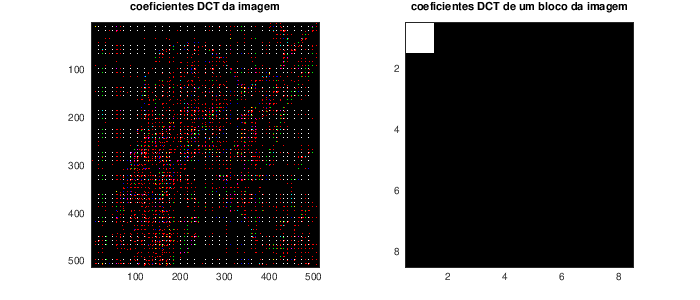

In [8]:
figure(2,'position',[0,0,700,300]);
subplot(1,2,1);
image(Bq); title('coeficientes DCT da imagem'); colormap('gray');
subplot(1,2,2);
image(Bq(9:16,9:16,1)); title('coeficientes DCT de um bloco da imagem'); colormap('gray');

Observe que há um valor maior (em branco), o coeficiente DC, e 15 valores nulos ou próximos de zero (preto), os coeficintes AC.

Devemos agora varrer os coeficientes fazendo um zig-zag, para assim ordená-los em ordem crescente de frequência. Iremos utilizar a função zig-zag disponível no [Rosettacode](https://rosettacode.org/wiki/Zig-zag_matrix#MATLAB).

In [9]:
function matrix = zigzag(n)
 
    %This is very unintiutive. This algorithm parameterizes the
    %zig-zagging movement along the matrix indicies. The easiest way to see
    %what this algorithm does is to go through line-by-line and write out
    %what the algorithm does on a peace of paper. 
 
    matrix = zeros(n);
    counter = 1;
    flipCol = true;
    flipRow = false;
 
    %This for loop does the top-diagonal of the matrix
    for i = (2:n)
        row = (1:i);
        column = (1:i);
 
        %Causes the zig-zagging. Without these conditionals, 
        %you would end up with a diagonal matrix. 
        %To see what happens, comment these conditionals out.         
        if flipCol
            column = fliplr(column);
            flipRow = true;
            flipCol = false;
        elseif flipRow
            row = fliplr(row);
            flipRow = false;
            flipCol = true;           
        end
 
        %Selects a diagonal of the zig-zag matrix and places the 
        %correct integer value in each index along that diagonal
        for j = (1:numel(row))
            matrix(row(j),column(j)) = counter;
            counter = counter + 1;
        end   
    end
 
    %This for loop does the bottom-diagonal of the matrix
    for i = (2:n)
        row = (i:n);
        column = (i:n);
 
        %Causes the zig-zagging. Without these conditionals, 
        %you would end up with a diagonal matrix. 
        %To see what happens comment these conditionals out. 
        if flipCol
            column = fliplr(column);
            flipRow = true;
            flipCol = false;
        elseif flipRow
            row = fliplr(row);
            flipRow = false;
            flipCol = true;           
        end
 
        %Selects a diagonal of the zig-zag matrix and places the 
        %correct integer value in each index along that diagonal
        for j = (1:numel(row))
            matrix(row(j),column(j)) = counter;
            counter = counter + 1;
        end   
    end
 
end

A função retorna uma matriz, com o tamanho desejado, com números dispostos na ordem em que devemos lê-los para efeturar a leitura em zig-zag. Iremos utilizar os índices obtidos no ordenamento desta matriz, quando convertida em vetor. Quando fazemos ```zz(:)```, estamos convertendo a matriz ```zz``` em um vetor coluna, seguindo as colunas da matriz, uma a cada vez (em inglês *columnwise*). A ordem de leitura de elementos no GNU Octave é: coluna, linha, etc.

In [10]:
zz = zigzag(8);
[zs, id] = sort(zz(:));
readzigzag = @(block_struct) block_struct(id);
sz = size(Bq);
nblocks = prod(sz(1:2)/8);
for c=1:size(X,3),
  Bzz = blockproc(Bq(:,:,c), [8 8], readzigzag);
  Bcoefs(:,:,c) = reshape(Bzz,64,nblocks);
endfor
size(Bcoefs)

ans =

     64   4096      3



Organizamos os coeficientes de forma que a primeira linha da matriz ```Bcoefs``` contém os coeficientes DC e as demais linhas os coeficientes AC.

In [11]:
Bdc = Bcoefs(1,:,:); % coeficientes DC
Bac = Bcoefs(2:end,:,:); % coeficientes AC
size(Bdc), size(Bac)

ans =

      1   4096      3

ans =

     63   4096      3



Faremos agora a codificação DPCM dos coeficientes DC. Podemos realizar a codificação DPCM de todos coeficientes DC juntos (3 canais) ou podemos utilizar uma codificação diferente para cada canal ou ainda uma codificação para o canal de luminância Y e outra para os canais de crominância (Cb e Cr). O código abaixo apresenta duas opções: 1) todos canais juntos; 2) todos canais separados. A segunda opção está comentada. Para verificar as diferenças, rode novamente o código fazendo a adaptação.

Observe abaixo algumas estatísticas dos coeficientes DC associados a cada um dos canais.

In [12]:
printf('canal Y: média = %.2f, desvio padrão = %.2f\n', mean(Bdc(1,:,1)), std(Bdc(1,:,1)));
printf('canal Cb: média = %.2f, desvio padrão = %.2f\n', mean(Bdc(1,:,2)), std(Bdc(1,:,2)));
printf('canal Cr: média = %.2f, desvio padrão = %.2f\n', mean(Bdc(1,:,3)), std(Bdc(1,:,3)));

canal Y: média = 61.27, desvio padrão = 19.26
canal Cb: média = 55.89, desvio padrão = 5.35
canal Cr: média = 76.81, desvio padrão = 5.01


Iremos utilizar a função ```dpcmopt``` para encontrar o preditor e quantizador ótimos para o sinal a ser codificado.

Nota: no GNU Octave a função está com erro na linha 62:

```predictor = [0 - a(2:end)];```

Para corrigir o erro, basta remover o espaço entre o menos (-) e o vetor a.
Deverá ficar da seguinte forma:

```predictor = [0 -a(2:end)];```

In [13]:
% DPCM separado para cada canal
%[dpcmpredictor_y, dpcmcodebook_y, dpcmpartition_y] = dpcmopt(Bdc(1,:,1), 3, 2^4);
%[dpcmpredictor_cb, dpcmcodebook_cb, dpcmpartition_cb] = dpcmopt(Bdc(1,:,2), 3, 2^4);
%[dpcmpredictor_cr, dpcmcodebook_cr, dpcmpartition_cr] = dpcmopt(Bdc(1,:,3), 3, 2^4);
%qidxdpcm_y = dpcmenco(Bdc(1,:,1), dpcmcodebook_y, dpcmpartition_y, dpcmpredictor_y);
%qidxdpcm_cb = dpcmenco(Bdc(1,:,2), dpcmcodebook_cb, dpcmpartition_cb, dpcmpredictor_cb);
%qidxdpcm_cr = dpcmenco(Bdc(1,:,3), dpcmcodebook_cr, dpcmpartition_cr, dpcmpredictor_cr);

% DPCM único para os 3 canais
[dpcmpredictor, dpcmcodebook, dpcmpartition] = dpcmopt(Bdc(:)', 3, 2^4);
qidxdpcm = dpcmenco(Bdc(:)', dpcmcodebook, dpcmpartition, dpcmpredictor);

E, por fim, é realizada a codificação RLE dos coeficientes AC.

In [14]:
acrle = rleenco(Bac(:));
size(acrle)

ans =

       1   79478



Os próximos passos seria a codificação de entropia (Huffman ou codificação aritmética) e salvar as informações em arquivo. Nâo iremos realizar estes passos aqui.

### Decodificação JPEG

O processo de decodificação JPEG deve fazer o caminho inverso.

Vamos recuperar os coeficientes AC e DC, utilizando as funções de decodificação para RLE e DPCM, respectivamente.

In [15]:
bacr = rledeco(acrle);
% DPCM separado para cada canal
%bdcr_y = dpcmdeco(qidxdpcm_y, dpcmcodebook_y, dpcmpredictor_y);
%bdcr_cb = dpcmdeco(qidxdpcm_cb, dpcmcodebook_cb, dpcmpredictor_cb);
%bdcr_cr = dpcmdeco(qidxdpcm_cr, dpcmcodebook_cr, dpcmpredictor_cr);

% DPCM único para os 3 canais
bdcr = dpcmdeco(qidxdpcm, dpcmcodebook, dpcmpredictor);

Vamos definir abaixo a função ```mse``` para calcular o erro médio quadrático (MSE - *mean squared error*) nas codificações das componentes.

In [16]:
function e = mse(x,y)
   if size(x) != size(y), error('Os vetores devem ter o mesmo tamanho!'); endif
   e = sum((x - y).^2)/length(x);
endfunction

Como esperado, o erro da codificação RLE é nulo:

In [17]:
mse(Bac(:)', bacr)

ans = 0


O DPCM insere erro, uma vez que a predição não é ideal e o erro de predição é quantizado. Teste variar a ordem do preditor e o número de bits do quantizador no DPCM. Verifique os efeitos desta mudança no MSE e na qualidade da imagem final.

In [18]:
% DPCM separado para cada canal
%mse(Bdc(1,:,1),bdcr_y)
%mse(Bdc(1,:,2),bdcr_cb)
%mse(Bdc(1,:,3),bdcr_cr)
% DPCM único para os 3 canais
mse(Bdc(:)', bdcr)

ans =  3.2403


Vamos agora reorganizar os coeficientes AC e DC recuperados.

In [19]:
yac = reshape(bacr,63,length(bacr)/(63*3),3);
%ydc = reshape([bdcr_y bdcr_cb bdcr_cr],1,length(bdcr_y),3); % DPCM separado para cada canal
ydc = reshape(bdcr,1,length(bdcr)/3,3); % DPCM único para os 3 canais

ycoefs = [ydc; yac];
yzz = reshape(ycoefs,64*size(X,1)/8,size(X,2)/8,3);
whos yzz

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        yzz      4096x64x3                 6291456  double

Total is 786432 elements using 6291456 bytes



Em seguida, iremos reverter o ordenamento em zig-zag, voltando para a configuração inicial.

In [20]:
% undo zigzag
it=[1:64]'; iv(id)=it;
dezigzag = @(block_struct) reshape(block_struct(iv),8,8);
for c=1:size(X,3),
  y(:,:,c) = blockproc(yzz(:,:,c), [64 1], dezigzag);
endfor
whos y

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        y         512x512x3                6291456  double

Total is 786432 elements using 6291456 bytes



Abaixo é realizada a mudança de escala, multiplicando pelos coeficientes da matriz de quantização. Seria como reverter a quantização, exceto pela informação perdida no erro de quantização.

In [21]:
% undo quantize
for c=1:size(X,3),
  yr(:,:,c) = blockproc(y(:,:,c), [8 8], @(block_struct) block_struct.*m(:,:,c));
endfor

Definiremos abaixo a função ```invdct``` para efeturar a DCT 2D inversa.

In [22]:
% iDCT 
invdct = @(block_struct) T' * block_struct * T; 

E agora aplicaremos a DCT inversa em cada bloco 8x8 da matriz.

In [23]:
for c=1:size(X,3),
  Xrycbcr(:,:,c) = blockproc(yr(:,:,c),[8 8],invdct);
endfor
whos Xrycbcr

Variables in the current scope:

   Attr Name         Size                     Bytes  Class
   ==== ====         ====                     =====  ===== 
        Xrycbcr    512x512x3                6291456  double

Total is 786432 elements using 6291456 bytes



Por fim, iremos voltar para o espaço de cores RGB e mostrar a imagem recuperada.

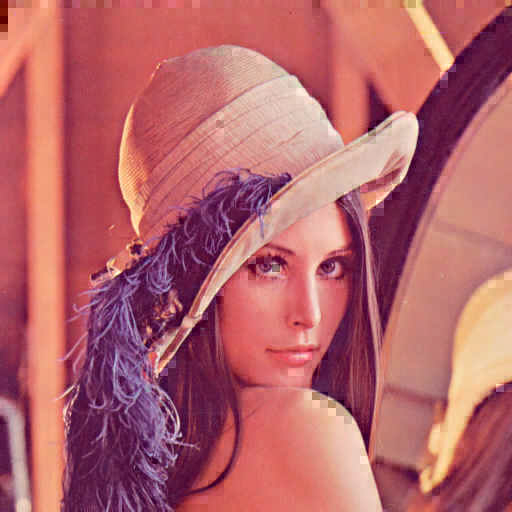

In [24]:
Xr = ycbcr2rgb(uint8(Xrycbcr));
imshow(im2double(Xr));